# Interactive tool for analyzing Moon

### Imports 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import cv2
import math
import itertools
import urllib.request
import pandas as pd
from numpy import genfromtxt
from sklearn.linear_model import LinearRegression, BayesianRidge, SGDRegressor
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor
import sklearn.metrics as skmetrics
from ipywidgets import interact, interactive, fixed, interact_manual
from matplotlib.patches import Circle
import ipywidgets as widgets
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.patches as mpatches

### Functions

Defining functions for splitting the datasets, training the models and plotting the plots.

In [ ]:
score_types = ["r2","mse","rmse","mae"]

def split(albedo, fe, k, th, ti):
  chemicals = np.array(list(zip(albedo, fe, k, th, ti)))
  n = len(chemicals)//2
  train_set = chemicals[:n]
  test_set = chemicals[n:]
  train_set_x, train_set_y = train_set[:,1:], train_set[:,0]
  test_set_x, test_set_y  = test_set[:,1:], test_set[:,0]
  return train_set_x, train_set_y, test_set_x, test_set_y

def train_model(albedo, fe, k, th, ti):
  """Data processing. Create train and test sets by splitting the image in a half."""
  train_set_x, train_set_y, test_set_x, test_set_y = split(albedo, fe, k, th, ti)
  model = LinearRegression().fit(train_set_x, train_set_y)
  return model

def plot_side_by_side(img1, img2, figsize=(30,45), vmin=0.1, vmax=0.5, title=None):
  plt.figure(figsize=figsize)
  x= np.zeros((3,len(img1))).T
  plt.imshow(np.concatenate([img1,x, img2],axis=1), vmin=vmin, vmax=vmax)
  if title:
    plt.title(title)

Defining custom blurring functions. In particular, we define a gaussian blur whose sigma is modified for each pixel depending on the surface to operate in spherical coordinates to ensure that the smoothing is equivalent in equatorial and polar regions. For that purpose we estimate the proportion of the area based on the diameter of the circumference at that point.

In [ ]:
def gaussianKernel(size, sigma):
    kernel =  np.fromfunction(lambda x, y: (1/(2*math.pi*sigma**2)) * math.e ** ((-1*((x-(size-1)/2)**2+(y-(size-1)/2)**2))/(2*sigma**2)), (size, size))
    return kernel / np.sum(kernel)

def gaussianBlurAdaptative(img, kSize, kSigma):
    assert kSize % 2 == 1
    kernel = gaussianKernel(kSize, kSigma)
    d = int((kSize-1)/2)
    my,mx, = img.shape
    gaussian = np.zeros((my,mx))
    sigmas =  np.zeros((my,mx))
    ksizes =  np.zeros((my,mx))
    for y in range(my):
        if y < 180:
          diameterRatio = y
        else:
          diameterRatio = my-y
        kSigma2 = max(1,(kSigma * (diameterRatio/180)))
        for x in range(mx):
            sigmas[y][x] = kSigma2
            #borders
            y1 = min(d,y)
            if d+y > my-1:
              y2 = my-1-y
            else:
              y2 = d
            x1 = min(d,x)
            if d+x > mx-1:
              x2 = mx-1-x
            else:
              x2 = d
            d3 = min(y1,y2,x1,x2)
            img2 = img[y-d3:y+d3+1,x-d3:x+d3+1]
            kernel2 = gaussianKernel(min(img2.shape), kSigma2)
            ksizes[y][x] = min(img2.shape)
            gaussian[y][x] = np.sum(np.multiply(img2, kernel2))
    return gaussian,sigmas,ksizes

### Data loading

Load the datasets directly from Github.

In [ ]:
def get_datasets():
  datasets_links = {"light": "Albedo_Map.csv",
                  "fe" : "LPFe_Map.csv",
                  "k" : "LPK_Map.csv",
                  "th" : "LPTh_Map.csv",
                  "ti" : "LPTi_Map.csv"
                  }

  datasets_img = {} #2-D array of pixels

  for key, value in datasets_links.items():
    response = urllib.request.urlopen('https://raw.githubusercontent.com/strukovas/MLMAPPER/main/data/Moon/'+value)
    lines = [l.decode('utf-8') for l in response.readlines()]
    datasets_img[key] = genfromtxt(lines, delimiter=',')
  return datasets_img

datasets_img = get_datasets()

In [ ]:
best_sigma = 9
best_ksize = (21,21)

In [ ]:
fe,k,th,ti = datasets_img['fe'].flatten(), datasets_img['k'].flatten(), datasets_img['th'].flatten(), datasets_img['ti'].flatten()
train_set_x, train_set_y, test_set_x, test_set_y = split(datasets_img['light'].flatten(), fe,k,th,ti)

In [ ]:
light_original = datasets_img["light"]
model1 = train_model(light_original.flatten(),fe,k,th,ti)

light_blur = cv2.GaussianBlur(datasets_img["light"], ksize=best_ksize, sigmaX = best_sigma)
model2 = train_model(light_blur.flatten(),fe,k,th,ti)

light_blur_adaptative, _, _= gaussianBlurAdaptative(datasets_img["light"], 21, best_sigma)
model3 = train_model(light_blur_adaptative.flatten(),fe,k,th,ti)

predicted = np.concatenate([model1.predict(train_set_x), model1.predict(test_set_x)])
predicted = predicted.reshape(360,720)
predicted_blur = np.concatenate([model2.predict(train_set_x), model2.predict(test_set_x)])
predicted_blur = predicted_blur.reshape(360,720)
predicted_blur_adaptative = np.concatenate([model2.predict(train_set_x), model2.predict(test_set_x)])
predicted_blur_adaptative = predicted_blur_adaptative.reshape(360,720)

In [ ]:
def f(error_threshold, min_area, filled, correct_img, training_img, background_img):
  vmax = 0.5
  vmin = 0.1

  if correct_img == 'original':
    correct_img = datasets_img["light"].copy()
  elif correct_img == 'blurred':
    correct_img = light_blur
  elif correct_img == 'blurred_adaptative':
    correct_img = light_blur_adaptative
  
  if training_img == 'original':
    predicted_img = predicted
  elif training_img == 'blurred':
    predicted_img = predicted_blur
  elif training_img == 'blurred_adaptative':
    predicted_img = predicted_blur_adaptative

  error_img = correct_img - predicted_img

  # Obtain contours of positive error
  f = plt.figure(figsize=(22,10))
  x1 = error_img.copy()
  x1 = np.ma.masked_where(x1 < error_threshold, x1)
  x1[x1 >= error_threshold] = 1
  x1 = np.array(x1 * 255, dtype = np.uint8)

  cnts, hiers  = cv2.findContours(x1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  contours_positive = []
  for cnt in cnts:
    area = cv2.contourArea(cnt)
    if area > min_area:
      contours_positive.append(cnt)

  # Obtain contours of negative error
  x2 = error_img.copy()
  x2 = np.ma.masked_where(x2 > -error_threshold, x2)
  x2[x2 < -error_threshold] = 1
  x2 = abs(x2)
  x2 = np.array(x2 * 255, dtype = np.uint8)

  cnts, hiers  = cv2.findContours(x2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  contours_negative = []
  for cnt in cnts:
    area = cv2.contourArea(cnt)
    if area > min_area:
      contours_negative.append(cnt)

  if background_img == 'original':
    p = datasets_img["light"].copy()
  elif background_img == 'blurred':
    p = light_blur.copy()
  elif background_img == 'blurred_adaptative':
    p = light_blur_adaptative.copy()
  elif background_img == 'error':
    p = error_img.copy()
    vmax = np.amax(p)
    vmin = np.amin(p)
  elif background_img == 'training_img':
    p = training_img.copy()

  norm = mpl.colors.Normalize(vmax=vmax, vmin=vmin)
  m = cm.ScalarMappable(norm=norm, cmap=cm.viridis)
  p = m.to_rgba(p)
  final_img = np.array(p * 255, dtype = np.uint8)

  if filled:
    cv2.drawContours(final_img, contours_positive, -1, (255, 0, 0, 255), thickness=cv2.FILLED)
    cv2.drawContours(final_img, contours_negative, -1, (0, 0, 0, 255), thickness=cv2.FILLED)
  else:
    cv2.drawContours(final_img, contours_positive, -1, (255, 0, 0, 255))
    cv2.drawContours(final_img, contours_negative, -1, (0, 0, 0, 255))
  plt.imshow(final_img, vmax=vmax, vmin=vmin)
  plt.colorbar()

  red_patch = mpatches.Patch(color='red', label='Positive error')
  black_patch = mpatches.Patch(color='black', label='Negative error')
  plt.legend(handles=[red_patch,black_patch],bbox_to_anchor=(0.22, -0.05), ncol=2)

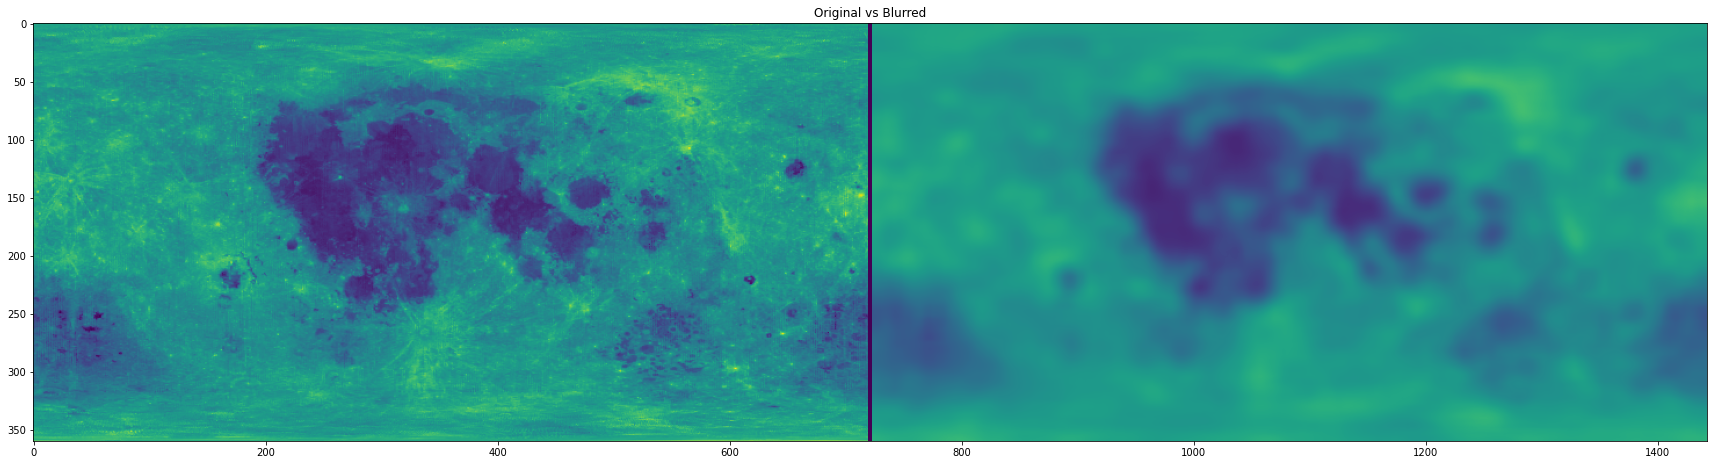

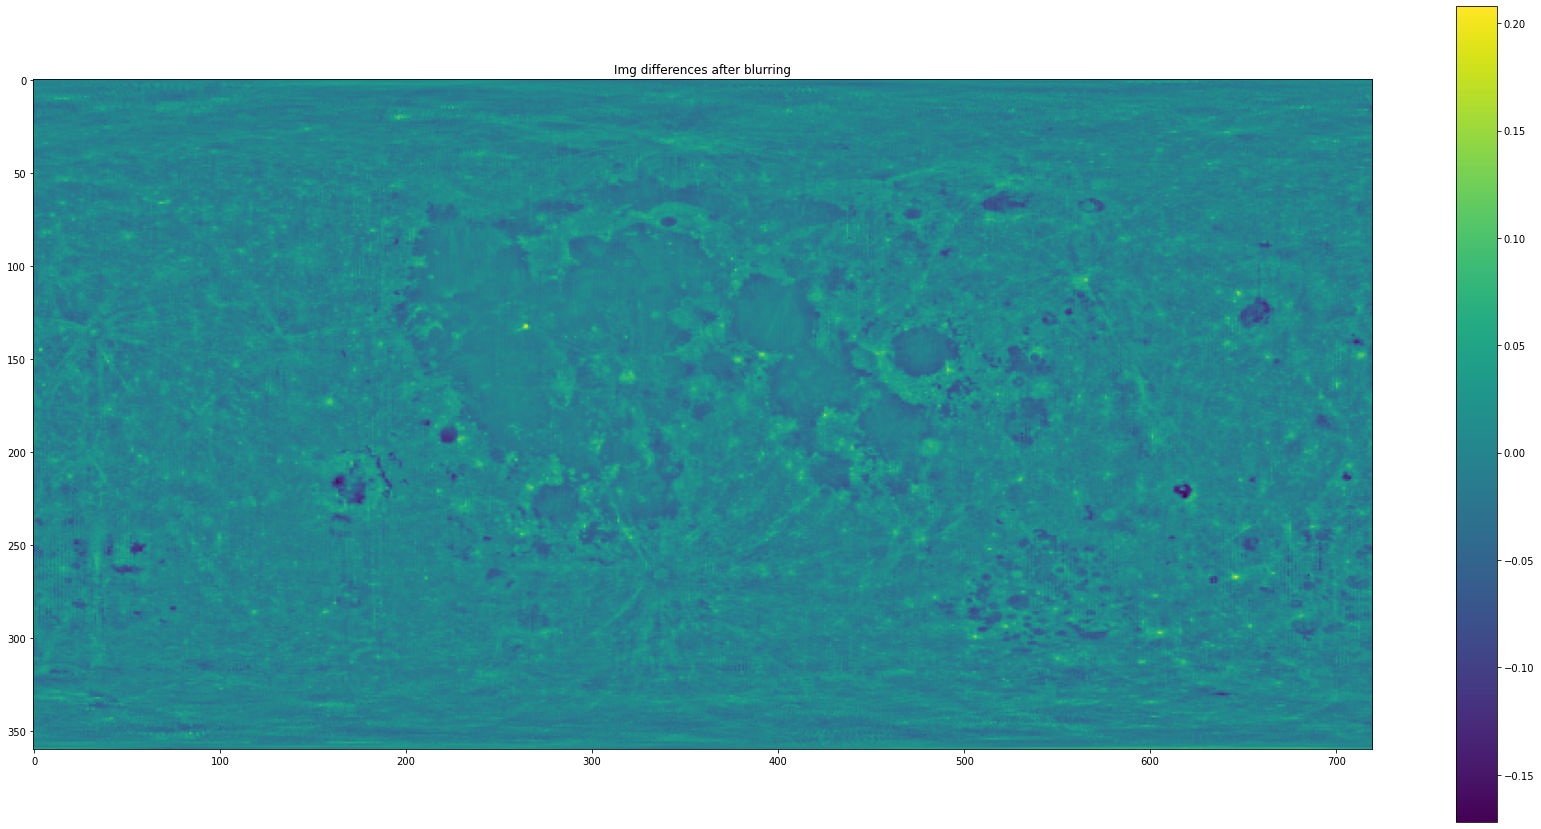

In [ ]:
plot_side_by_side(light_original,light_blur, title="Original vs Blurred")

plt.figure(figsize=(30,15))
plt.title("Img differences after blurring")
plt.imshow((light_original-light_blur))
plt.colorbar();

## Interactive analysis
The following interactive analyzer displays contours around regions of pixels whose error value is higher than error_threshold. These contours are red if the error is positive, and black if negative.

Note that error is computed as **(correct_img - predicted_img)**.
Where predicted_img is generated by the model after being trained on training_img.

 - **mask_threshold**: Only consider those pixel whose prediction error is higher than this.
 - **min_area**: Discard contours whose are is smaller than this.
 - **filled**: Fills the contours.
 - **correct_img**: Image to be used a the correct one for computing the error.
 - **training_img**: Image to be used to train the ML model.
 - **background_img**: Image to be displayed in the background. If you select training_img it will display the image specified in the parameter "training_img".


In [ ]:
@interact(error_threshold=widgets.FloatSlider(min=0., max=0.12, step=0.01, value=0.04,continuous_update=False),
          min_area=widgets.IntSlider(min=0, max=300, step=10, value=40,continuous_update=False),
          filled=False,
          correct_img=['original','blurred','blurred_adaptative'],
          training_img=['original', 'blurred','blurred_adaptative'],
          background_img=['original', 'blurred', 'blurred_adaptative','training_img','error'])
def g(error_threshold, min_area, filled, correct_img, training_img, background_img):
  f(error_threshold, min_area, filled, correct_img, training_img, background_img)
  plt.title(f'error_threshold={error_threshold} | min_area={min_area} | filled={filled} | correct_img={correct_img} | training_img={training_img} | background_img={background_img}')


interactive(children=(FloatSlider(value=0.04, continuous_update=False, description='error_threshold', max=0.12…